# Named Entity Recognition with DistilBERT on BC5CDR dataset

In [21]:
task = "ner" # could be one of "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
label_all_tokens = True

# 1. Loading the dataset

In [22]:
# !pip install evaluate
# !pip install seqeval
from datasets import load_dataset
from evaluate import load
import transformers
import numpy as np
import matplotlib.pyplot as plt


from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer, 
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)

from datasets import load_dataset, DatasetDict, ClassLabel, Sequence


print(transformers.__version__)

4.47.0


In [23]:
datasets = load_dataset("tner/bc5cdr",trust_remote_code=True)

In [24]:
datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5228
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5330
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5865
    })
})

In [25]:
datasets["train"][0]

{'tokens': ['Naloxone',
  'reverses',
  'the',
  'antihypertensive',
  'effect',
  'of',
  'clonidine',
  '.'],
 'tags': [1, 0, 0, 0, 0, 0, 1, 0]}

In [26]:


datasets = load_dataset("tner/bc5cdr", trust_remote_code=True)


label_list = ["O", "B-Chemical", "B-Disease", "I-Disease", "I-Chemical"]
label_dict = {label: i for i, label in enumerate(label_list)}


ner_feature = Sequence(ClassLabel(names=label_list))


def update_format(example):
    example["ner_tags"] = example.pop("tags")  # 重命名 tags -> ner_tags
    return example

datasets = datasets.map(update_format)

datasets = datasets.cast_column("ner_tags", ner_feature)


print(datasets["train"].features)


{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Chemical', 'B-Disease', 'I-Disease', 'I-Chemical'], id=None), length=-1, id=None)}


———

In [27]:
datasets["train"][0]

{'tokens': ['Naloxone',
  'reverses',
  'the',
  'antihypertensive',
  'effect',
  'of',
  'clonidine',
  '.'],
 'ner_tags': [1, 0, 0, 0, 0, 0, 1, 0]}

In [28]:
print(datasets["train"].features["ner_tags"])


Sequence(feature=ClassLabel(names=['O', 'B-Chemical', 'B-Disease', 'I-Disease', 'I-Chemical'], id=None), length=-1, id=None)


In [29]:
label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list

['O', 'B-Chemical', 'B-Disease', 'I-Disease', 'I-Chemical']

# 2. Preprocessing the data

In [30]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [31]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [32]:
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[101, 6583, 4135, 22500, 2063, 7901, 2015, 1996, 3424, 10536, 4842, 25808, 3512, 3466, 1997, 18856, 10698, 10672, 1012, 102], [101, 1999, 14477, 5267, 10760, 23355, 1010, 27491, 23760, 25808, 3512, 11432, 1996, 9885, 1999, 2668, 3778, 1998, 2540, 3446, 2550, 2011, 26721, 8159, 3560, 18856, 10698, 10672, 1010, 1019, 2000, 2322, 12702, 13113, 2015, 1013, 4705, 1010, 2001, 26402, 2098, 2030, 11674, 2011, 6583, 4135, 15975, 1010, 1014, 1012, 102], [101, 1016, 2000, 1016, 11460, 1013, 4705, 1012, 102], [101, 1996, 1044, 22571, 12184, 3619, 3512, 3466, 1997, 2531, 11460, 1013, 4705, 6541, 1011, 25003, 3527, 4502, 2001, 2036, 6822, 11674, 2011, 6583, 4135, 22500, 2063, 1012, 102], [101, 6583, 4135, 22500, 2063, 2894, 2106, 2025, 7461, 2593, 2668, 3778, 2030, 2540, 3446, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [33]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

# 3. Fine-tuning the model

In [34]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to = 'none',
    load_best_model_at_end=True,  
    metric_for_best_model="f1", 
    greater_is_better=True,
)

In [36]:
data_collator = DataCollatorForTokenClassification(tokenizer)

metric = load("seqeval")

# labels = [label_list[i] for i in example[f"{task}_tags"]]
# metric.compute(predictions=[labels], references=[labels])

In [37]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [38]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    # tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 4. Model Training

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.158815,0.867449,0.841087,0.854064,0.944527
2,0.214900,0.148944,0.860926,0.899660,0.879867,0.950429
3,0.214900,0.156193,0.880436,0.896401,0.888347,0.953373
4,0.076300,0.177030,0.882088,0.898472,0.890205,0.953746
5,0.034300,0.191975,0.888216,0.896027,0.892104,0.954472
6,0.034300,0.207638,0.889068,0.898065,0.893544,0.954879
7,0.018800,0.218801,0.888930,0.896537,0.892717,0.954574
8,0.011900,0.228228,0.877848,0.913141,0.895147,0.954968
9,0.011900,0.230575,0.890581,0.897657,0.894105,0.955063
10,0.006200,0.231050,0.887268,0.904380,0.895742,0.955361


TrainOutput(global_step=3270, training_loss=0.055870539332748555, metrics={'train_runtime': 362.2946, 'train_samples_per_second': 144.302, 'train_steps_per_second': 9.026, 'total_flos': 1033673156087136.0, 'train_loss': 0.055870539332748555, 'epoch': 10.0})

# 5. Model Evaluation

In [40]:
trainer.evaluate()

{'eval_loss': 0.23105038702487946,
 'eval_precision': 0.8872676394163502,
 'eval_recall': 0.9043803056027164,
 'eval_f1': 0.8957422479316607,
 'eval_accuracy': 0.9553610800176385,
 'eval_runtime': 10.3617,
 'eval_samples_per_second': 514.395,
 'eval_steps_per_second': 32.234,
 'epoch': 10.0}

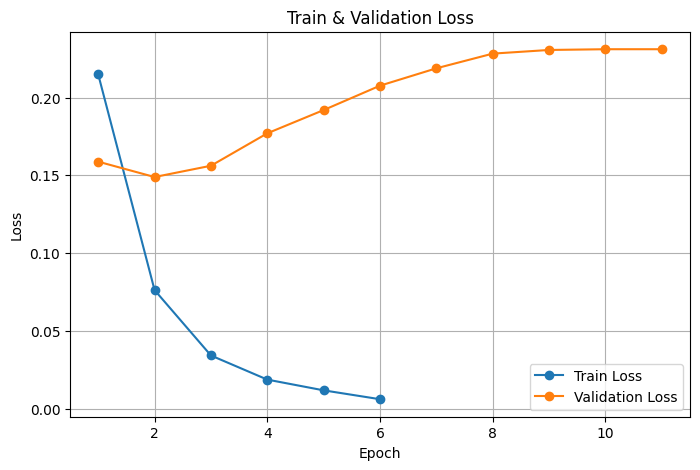

In [41]:
import matplotlib.pyplot as plt


logs = trainer.state.log_history


train_losses = [entry['loss'] for entry in logs if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]


epochs_train = list(range(1, len(train_losses) + 1))
epochs_eval = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs_train, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_eval, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train & Validation Loss")
plt.grid()
plt.show()

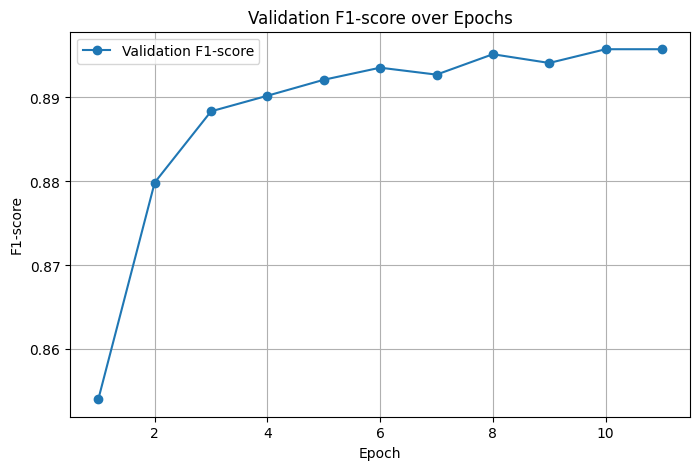

In [42]:
f1_scores = [entry['eval_f1'] for entry in logs if 'eval_f1' in entry]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label="Validation F1-score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()
plt.title("Validation F1-score over Epochs")
plt.grid()
plt.show()


In [43]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print(test_results)


{'eval_loss': 0.23341412842273712, 'eval_precision': 0.876010159316555, 'eval_recall': 0.8994784257942152, 'eval_f1': 0.8875891917183296, 'eval_accuracy': 0.9539712232059347, 'eval_runtime': 11.3255, 'eval_samples_per_second': 517.857, 'eval_steps_per_second': 32.405, 'epoch': 10.0}


In [44]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print('Validation set:')
results

Validation set:


{'Chemical': {'precision': 0.9292073598446016,
  'recall': 0.9397544338335607,
  'f1': 0.9344511367952683,
  'number': 18325},
 'Disease': {'precision': 0.819590770570309,
  'recall': 0.8461123595505617,
  'f1': 0.832640424590889,
  'number': 11125},
 'overall_precision': 0.8872676394163502,
 'overall_recall': 0.9043803056027164,
 'overall_f1': 0.8957422479316607,
 'overall_accuracy': 0.9553610800176385}

In [45]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print('Test set:')
results

Test set:


{'Chemical': {'precision': 0.9165460684997588,
  'recall': 0.9351927809680065,
  'f1': 0.9257755400357317,
  'number': 18285},
 'Disease': {'precision': 0.8111492281303602,
  'recall': 0.8413842184858998,
  'f1': 0.8259901314353085,
  'number': 11241},
 'overall_precision': 0.876010159316555,
 'overall_recall': 0.8994784257942152,
 'overall_f1': 0.8875891917183296,
 'overall_accuracy': 0.9539712232059347}